In [1]:
from openhsl.hsi import HSImage
from openhsl.hs_mask import HSMask
from openhsl.data.utils import apply_pca
from openhsl.models.m1dcnn import M1DCNN
from openhsl.models.ssftt import SSFTT
from openhsl.data.utils import convert_to_color_
from openhsl.utils import draw_fit_plots

from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import numpy as np

import torch
import math
import pandas as pd

### Загрузим тестовый набор данных

In [2]:
hsi = HSImage()
mask = HSMask()

hsi.load('./test_data/tr_pr/PaviaU.mat', key='paviaU')
mask.load('./test_data/tr_pr/PaviaU_gt.mat', key='paviaU_gt')

#hsi.load('./pca_corn_1.mat', key='image')
#mask.load('./test_data/tr_pr/mask_corn_1.mat', key='img')

Created void HSI data
Wavelengths data is empty
Created void mask
Class labeles is empty
Metainfo file does not exist! Wavelengths will be empty.
Metainfo file does not exist!


### Зададим параметры обучения

In [3]:
optimizer_params = {
    "learning_rate": 0.1,
    "weight_decay": 0
}

scheduler_params = {
    "step_size": 2,
    "gamma": 0.5
}

fit_params = {
    "epochs": 3,
    'train_sample_percentage': 0.5,
    "dataloader_mode": "fixed",
    "optimizer_params": optimizer_params,
    "scheduler_params": scheduler_params,
    "batch_size": 32
}

### Создадим объект нейросетевого классификатора

Требуется указывать количество классов (n_classes), которые будут предсказываться и количество спектральных каналов (n_bands).

Для применения PCA требуется указать количество главных компонент в n_bands и поставить флаг True в параметре apply_pca.

Для загрузки весов предобученной модели требуется указать путь до них в параметре path_to_weights

Список доступных моделей из пакета openhsl.models
- fcnn.FCNN
- hsicnn.HSICNN
- m1dcnn.M1DCNN
- m3dcnn_hamida.M3DCNN
- m3dcnn_he.M3DCNN
- m3dcnn_li.M3DCNN
- m3dcnn_sharma.M3DCNN
- nm3dcnn.NM3DCNN
- tf2dcnn.TF2DCNN
- ssftt.SSFTT

### Применим PCA к данным для уменьшения их спектральной размерности

In [4]:
hsi.data, pca = apply_pca(hsi.data, num_components=30)

Will apply PCA from 103 to 30


In [5]:
cnn = SSFTT(n_classes=mask.n_classes,
            n_bands=hsi.data.shape[-1],
            #path_to_weights='../tests/checkpoints/nm3_dcnn__net/m3dcnn/2023_05_25_10_30_06_epoch3_0.85.pth',
            device='cuda')

### Обучение классификатора производится вызовом встроенного метода fit

In [6]:
cnn.fit(X=hsi,
        y=mask,
        fit_params=fit_params)

Sampling fixed with train size = 0.5 for train_val/test
Sampling fixed with train size = 0.9 for train/val


Train loop: 100%|█| 3/3 [00:24<00:00,  8.01s/it, train_acc=0.947, val_acc=0.964, train_loss=0.197, val_loss=0.133, lr=0


### Отрисуем графики обучения

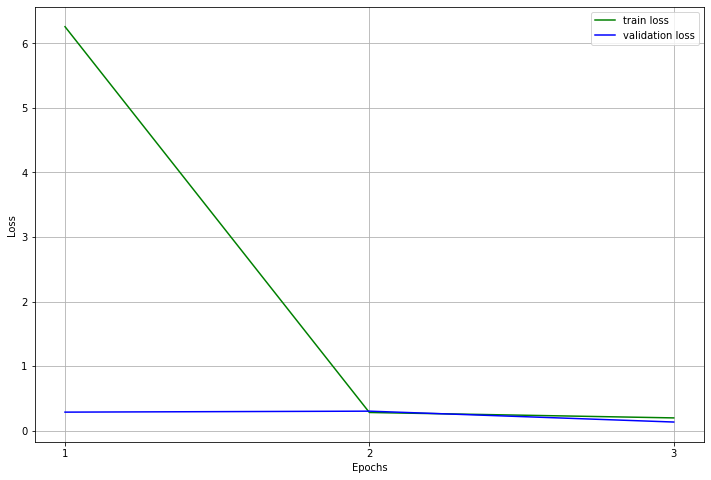

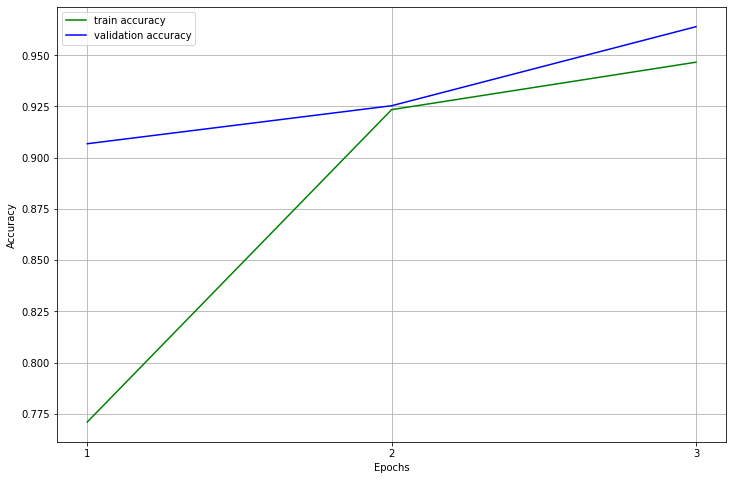

In [7]:
draw_fit_plots(model=cnn)

### Инференс классификатора производится вызовом встроенного метода predict

In [8]:
pred = cnn.predict(X=hsi)

# Отобразим только размеченные области
pred = pred * (mask.get_2d() > 0)

Inference on the image: 3065it [00:08, 340.86it/s]                                                                     


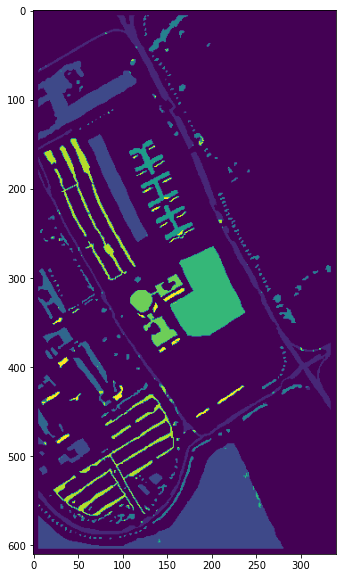

In [9]:
# Отрисуем результат инференса
plt.figure(figsize=(10,10))
plt.imshow(pred)
plt.show()

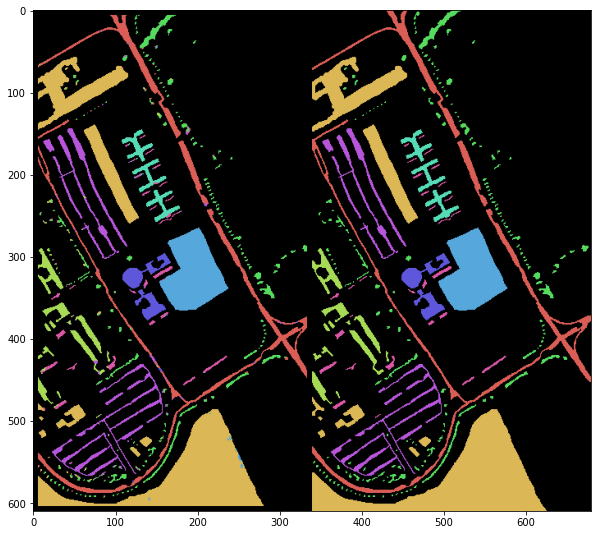

In [10]:
# Для большей наглядности раскрасим маски и отрисуем результат инференса (слева) вместе с эталоном (справа)

color_pred = convert_to_color_(pred)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack((color_pred, convert_to_color_(mask.get_2d()))))
plt.show()

In [11]:
# Получим метрики классификации
report = classification_report(mask.get_2d().flatten(), pred.flatten(), output_dict=True)

In [12]:
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,0.983035,1.000000,0.991445,164624.000000
1,0.987901,0.923541,0.954638,6631.000000
2,0.992849,0.878546,0.932207,18649.000000
3,0.926347,0.892806,0.909267,2099.000000
4,0.986036,0.829634,0.901099,3064.000000
5,0.989458,0.976952,0.983165,1345.000000
6,0.982978,0.999006,0.990927,5029.000000
7,0.967930,0.998496,0.982976,1330.000000
8,0.941161,0.994840,0.967256,3682.000000
9,0.901075,0.884900,0.892914,947.000000
